('Original Image Shape', (520, 696, 3))


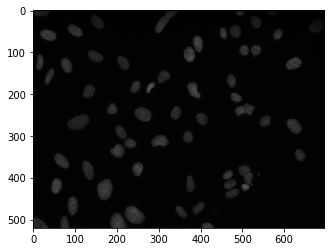

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import pathlib
import cv2

training_paths = pathlib.Path('../input/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]

img_org = cv2.imread(str(im_path))
plt.imshow(img_org)
print('Original Image Shape',img_org.shape)

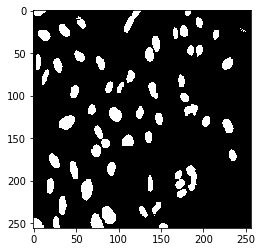

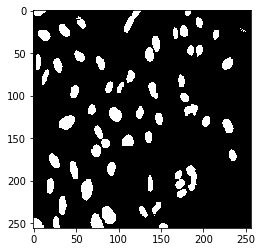

In [48]:
from skimage.filters import threshold_otsu
from scipy import ndimage

def gen_mask(img):
    # 1 Resizes image to desired size
    desiredShape = (256,256)
    img_1 = cv2.resize(img,desiredShape)
    
    # 2 Convert to Grayscale
    img_2 = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
    
    # 3 Remove background from image using otsu
    thresh_val = threshold_otsu(img_2)
    img_3 = np.where(img_2 > thresh_val-2,1,0)
    plt.imshow(img_3, cmap='gray')
    plt.show()
    
    # 4 Complete mask
    img_4 = ndimage.binary_fill_holes(img_3).astype(int)
    plt.imshow(img_4, cmap='gray')
    
    return img_4

img_res = gen_mask(img_org)

In [51]:
from skimage.feature import hog
from skimage.exposure import rescale_intensity

def gen_mask_hog(img):
    # 1 Resizes image to desired size
    desiredShape = (256,256)
    img_1 = cv2.resize(img,desiredShape)
    
    # 2 Convert to Grayscale
    img_2 = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
 
    # 3 Remove background from image using otsu
    thresh_val = threshold_otsu(img_2)
    img_3 = np.where(img_2 > thresh_val-2,1,0)

    fd, hog_image = hog(img_3, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualise=True)

    hog_image_scl = rescale_intensity(hog_image)
    
    hog_image_blur  = cv2.blur(hog_image_scl, (5,5))
    hog_image_blur  = np.where(hog_image_blur>0.05, 1, 0)

    #plt.imshow(hog_image_scl,cmap='gray')
    return hog_image_blur
    
img_res = gen_mask_hog(img_org)

52


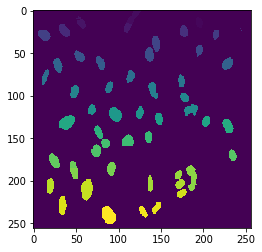

In [47]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed

def gen_mask_watershed(img):
    # 1 Resizes image to desired size
    desiredShape = (256,256)
    img_1 = cv2.resize(img,desiredShape)
    
    # 2 Convert to Grayscale
    img_2 = cv2.cvtColor(img_1,cv2.COLOR_BGR2GRAY)
    
    # 3 Remove background from image using otsu
    thresh_val = threshold_otsu(img_2)
    img_3 = np.where(img_2 > thresh_val-2,1,0)
        
    # 4 perform watershed segmentation
    distances = ndimage.distance_transform_edt(img_3)
    # Compute the local maximas, return T for peaks 
    peaks = peak_local_max(distances, indices=False, labels=img_3, min_distance=10)
    markers = ndimage.label(peaks,structure=np.ones((3, 3)))[0]
    img_4 = watershed(-distances, markers, mask=img_3)
    
    return img_4

img_res = gen_mask_watershed(img_org)
labels, nlabels = ndimage.label(img_res)
print nlabels
plt.imshow(img_res)

In [52]:
def rle_encode(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

def process_path(im_path):
    #Reading the image
    im_id = im_path.parts[-3] # Image ID
    im_img = cv2.imread(str(im_path)) # Reading image in OpenCV

    # Generate image mask
    mask = gen_mask_hog(im_img)
    
    #Extracting connected objects
    im_rle = pd.DataFrame()
    labels, nlabels = ndimage.label(mask) #labels gives us the label of the different objects in every image starting from 1 and nlabels gives us the total number of objects in every image
    for i in range(1,nlabels+1): # Iterating through every object/label
        label_mask = np.where(labels==i,1,0) # Individual masks for every nucleus
        RLE = rle_encode(label_mask)
        solution = pd.Series({'ImageId': im_id, 'EncodedPixels': RLE})
        im_rle = im_rle.append(solution, ignore_index=True)
    
    #Return the dataframe
    return(im_rle)

#Defining a function that takes a list of image paths (pathlib.Path objects), analyzes each and returns a submission ready DataFrame
def process_paths(im_path_list):
    all_df = pd.DataFrame()
    for im_path in im_path_list: 
        im_df = process_path(im_path) #Create one dataframe for every image 
        all_df = all_df.append(im_df, ignore_index=True) 
    
    #Returing the submission ready dataframe
    return (all_df)

test_images = pathlib.Path('../input/stage1_test/').glob('*/images/*.png')
basic_solution = process_paths(list(test_images))
basic_solution.to_csv('sol-4-sub-hogs.csv', index=None)

In [44]:
print basic_solution.shape

(1291, 2)
